# Temperature profiles for the UTLS region (12-20 km) for the 10x10 regions


In [1]:
import json
import pickle 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [2]:
file_path = "/work/bb1153/b380887/10x10/"
global_tropics_path = "/work/bb1153/b380887/global_tropics/"
pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/utls_temp_profiles/"


In [3]:
def get_mean_temps(model_list, region_list, start_date=None, end_date=None):
    """ 
    Get the time- and area-mean temperature for one model, all regions.
    Returns a dictionary with model names as keys and mean
    temperature data arrays as items. Input xdims is list of x dimension names
    to average over. Assumes time dimension is simply "time".
    """
    temp_dict_region = {}

    for region in region_list:
        temp_dict_models = {}

        for model in model_list:
            if model == "ERA5":
                try:
                    temp = xr.open_dataset(file_path + "{r}/ERA5_temp_0.25deg_ml_Feb2020_{r}.nc".format(r=region))["t"]
                except:
                    print("subsetting global file for region", region)
                    temp_itcz = xr.open_dataset(global_tropics_path + "obs/ERA5/ERA5_temp_0.25deg_ml_12-20km_Feb2020_ITCZ.nc")
                    if region == "SPC": 
                        temp_ds = temp_itcz.sel(longitude=slice(170, 180), latitude=slice(-5, -15))
                    elif region == "AMZ": 
                        temp_ds = temp_itcz.sel(longitude=slice(-65, -55), latitude=slice(-20, -30))
                    out_file = file_path + "{r}/ERA5_temp_0.25deg_ml_Feb2020_{r}.nc".format(r=region)
                    temp_ds.to_netcdf(out_file)
                    print("file saved to", out_file)
                    temp = temp_ds["t"]
                mean_temp = temp.sel(time=slice(start_date, end_date)).mean(dim=["time", "latitude", "longitude"])
            else:
                temp = xr.open_dataset(file_path + "{r}/{m}_temp_0.25deg_12-20km_winter_{r}.nc".format(r=region, m=model))["ta"]
                xdims = temp.dims[2:]
                mean_temp = temp.sel(time=slice(start_date, end_date)).mean(dim=[*xdims, "time"])
            temp_dict_models[model] = mean_temp
        
        temp_dict_region[region] = temp_dict_models
    
    return temp_dict_region
                                                                                    

In [4]:
start_date = "2020-01-30"
end_date = "2020-02-28"


In [5]:
region_list = ["SPC", "AMZ", "SCA", "TIM"]
model_list = ["ERA5", "SAM", "ICON", "SCREAM", "SHIELD", "GEOS"]


In [ ]:
%%time
tavg_dict = get_mean_temps(model_list, region_list, start_date=start_date, end_date=end_date)


#### Get ICON, SCREAM heights

In [7]:
temp_ispc = xr.open_dataset(file_path + "SPC/ICON_temp_12-20km_winter_SPC.nc")["ta"]
alt_i = xr.open_dataset(global_tropics_path + "ICON/ICON_altitude.nc")["height"].sel(lev=temp_ispc.height)

alt_sc = xr.open_dataset(global_tropics_path + "SCREAM/SCREAM_est_height_12-20km.nc")["z"]


#### Get ERA5 geopotential height

In [17]:
g = 9.80665
z_e_dict = {}

for region in region_list:
    try: 
        z_e = xr.open_dataset(file_path + "{r}/ERA5_zg_0.25deg_ml_Feb2020_{r}.nc".format(r=region))["z"].sel(level=tavg_dict["SCA"]["ERA5"].level)/g
    except:
        z_e_itcz = xr.open_dataset(global_tropics_path + "obs/ERA5/ERA5_zg_0.25deg_ml_ITCZ.nc")
        if region == "SPC": 
            z_ds = z_e_itcz.sel(longitude=slice(170, 180), latitude=slice(-5, -15))
        elif region == "AMZ": 
            z_ds = z_e_itcz.sel(longitude=slice(-65, -55), latitude=slice(-20, -30))
        out_file = file_path + "{r}/ERA5_zg_0.25deg_ml_Feb2020_{r}.nc".format(r=region)
        z_ds.to_netcdf(out_file)
        print("file saved to", out_file)
        z_e = z_ds["z"].sel(level=tavg_dict["SCA"]["ERA5"].level)/g
    
    z_e_avg = z_e.mean(dim=["time", "latitude", "longitude"])
    z_e_dict[region] = z_e_avg



#### Get SHIELD & GEOS heights
This takes a while!

In [8]:
%%time
# z_sh_list = [xr.open_dataset(file_path + "{r}/SHIELD_zg_12-20km_winter_{r}.nc".format(r=region))["zg"].mean(dim=["time", "Xdim"])
#               for region in region_list]
z_g_list = [xr.open_dataset(file_path + "{r}/GEOS_zg_12-20km_winter_{r}.nc".format(r=region))["zg"].mean(dim=["time", "Xdim"])
              for region in region_list]

# z_sh_dict = dict(zip(region_list, z_sh_list))
z_g_dict = dict(zip(region_list, z_g_list))


CPU times: user 17.4 s, sys: 22.8 s, total: 40.2 s
Wall time: 41.7 s


#### Save all the dictionaries

In [9]:
inits = ""
for model in list(tavg_dict["SCA"].keys()):
    inits += model[0]
    
for region in region_list:
    pickle_name = pickle_dir + "d2_utls_profiles/{i}_temp_dicts_UTLS_{r}.pickle".format(i=inits, r=region)
    with open(pickle_name, "wb") as handle:
        pickle.dump(tavg_dict[region], handle)
        

In [9]:
# with open(pickle_dir + "d2_utls_profiles/SHIELD_z_dicts_UTLS.pickle", "wb") as handle:
#      pickle.dump(z_sh_dict, handle)
with open(pickle_dir + "d2_utls_profiles/GEOS_z_dicts_UTLS.pickle", "wb") as handle:
    pickle.dump(z_g_dict,handle)
# with open(pickle_dir + "d2_utls_profiles/ERA5_z_dicts_UTLS.pickle", "wb") as handle:
#     pickle.dump(z_e_dict, handle)
    

## Read in the dictionaries once made

In [4]:
region_list = ["SPC", "AMZ", "SCA", "TIM"]
model_list = ["ERA5", "SAM", "ICON", "SCREAM", "SHIELD", "GEOS"]

inits = ""
for model in model_list:
    inits += model[0] 
    

Temperatures:

In [5]:
tavg_dict = {}

for region in region_list:
    pickle_name = pickle_dir + "d2_utls_profiles/{i}_temp_dicts_UTLS_{r}.pickle".format(i=inits, r=region)
    with open(pickle_name, "rb") as handle:
        tavg_dict[region] = pickle.load(handle)


Heights:

In [6]:
with open(pickle_dir + "d2_utls_profiles/SHIELD_z_dicts_UTLS.pickle", "rb") as handle:
    z_sh_dict = pickle.load(handle)
with open(pickle_dir + "d2_utls_profiles/GEOS_z_dicts_UTLS.pickle", "rb") as handle:
    z_g_dict = pickle.load(handle)
with open(pickle_dir + "d2_utls_profiles/ERA5_z_dicts_UTLS.pickle", "rb") as handle:
    z_e_dict = pickle.load(handle)

temp_isca = xr.open_dataset(file_path + "SCA/ICON_temp_12-20km_winter_SCA.nc")["ta"]
alt_i = xr.open_dataset(global_tropics_path + "ICON/ICON_altitude.nc")["height"].sel(lev=temp_isca.height)
alt_sc = xr.open_dataset(global_tropics_path + "SCREAM/SCREAM_est_height_12-20km.nc")["z"]


Mean soundings:

In [7]:
with open(pickle_dir + "sounding_mean_cold_points.pickle", "rb") as handle:
    soundings_dict = pickle.load(handle)
    

## Plots


In [14]:
title_dict = {
    "SAM": "gSAM",
    "SHIELD": "X-SHiELD",
    "ICON": "ICON",
    "GEOS": "GEOS", 
    "SCREAM": "SCREAM",
    "ERA5": "ERA5"
}


In [10]:
def plot_avg_temp_profiles(tavg_dict, z_dicts, soundings_dict, region, model_names, title_dict, fsize=14, tsize=16, zlims=(11500, 20900), xlims=(185, 227.5), figsize=(8, 6), 
                           zticks=[12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000], colors=None, 
                           shade_TTL=True, save=False):
    """ Plot time- and area-mean temperature profiles in UTLS region for one 10x10 region
    """
    if colors is None:
        with open(pickle_dir + "colormaps/dyamond2_colors.json", "r") as fp:
            colors = json.load(fp)
        
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(True, linestyle=":")

    if shade_TTL:
        ax.axhspan(14000, 18000, color="grey", alpha=0.25, label="TTL")
            
    for model in model_names:
         
        # get height - depends on region for some
        if model == "ERA5" or model == "SHIELD" or model == "GEOS":
            z_vals = z_dicts[model][region].values
        else:
            z_vals = z_dicts[model].values
            
        # plot height vs. temp
        ax.plot(tavg_dict[model], z_vals, color=colors[model], label=title_dict[model], zorder=1)
        ax.scatter(tavg_dict[model], z_vals, color=colors[model], s=15, zorder=2)

    # plot mean sounding
    if region == "SCA":
        sound_lab = "IGRA (Feb. 2002)"
    else:
        sound_lab = "IGRA (Feb. 2020)"
    ax.scatter(soundings_dict[region][0], soundings_dict[region][1]*1000., marker="P", color="k", s=150, zorder=3, label=sound_lab)

    ax.legend(loc="upper right", ncol=1, fontsize=fsize)
    ax.set_ylim(zlims)
    ax.set_xlim(xlims)
    ax.set_yticks(zticks)
    ax.set_yticklabels([str(int(z/1000)) for z in zticks])
    ax.tick_params(axis="both", labelsize=fsize-1)
    ax.set_ylabel("Altitude (km)", fontsize=fsize)
    ax.set_xlabel("Temperature (K)", fontsize=fsize)
    
    ax.set_title(region, fontsize=tsize)
        # "{r} Time- and Area-Mean Temperature".format(r=region), fontsize=tsize)
    
    if save:
        inits = ""
        for model in model_names:
            inits += model[0]
            
        plt.savefig(save_dir + "{i}_UTLS_temp_profiles_{r}.png".format(i=inits, r=region), dpi=300, bbox_inches="tight")
        
    plt.show()

    

KeyError: 'ERA5'

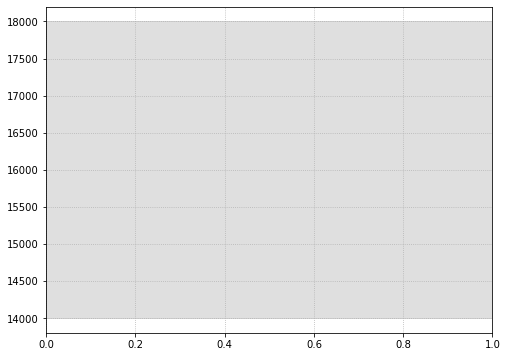

In [11]:
model_names = ["ERA5", "ICON", "GEOS", "SAM", "SCREAM", "SHIELD"]

# ERA5, SCREAM, SHIELD, GEOS are dictionaries - height changes by region
z_dicts = {
    "SAM": tavg_dict["SCA"]["SAM"].z,
    "ICON": alt_i,
    "SCREAM": alt_sc,
    "SHIELD": z_sh_dict,
    "GEOS": z_g_dict,
    "ERA5": z_e_dict
}

for region in region_list:
    t_dict = tavg_dict[region]
    plot_avg_temp_profiles(t_dict, z_dicts, soundings_dict, region, model_names, 
                           title_dict, tsize=18, save=True)
    


In [24]:
def plot_avg_temp_profiles_all(tavg_dicts, z_dicts, soundings_dict, region_list, model_names, title_dict, fsize=14, tsize=16, zlims=(11500, 20900), xlims=(185, 227.5), figsize=(16, 12), 
                           zticks=[12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000], colors=None, 
                           labsize=16, shade_TTL=True, save=False):
    """ Plot time- and area-mean temperature profiles in UTLS region for one 10x10 region
    """
    if colors is None:
        with open(pickle_dir + "colormaps/dyamond2_colors.json", "r") as fp:
            colors = json.load(fp)
        
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=figsize)
    plt.subplots_adjust(hspace=0.3)
    axes_dict = dict(zip(region_list, [ax1, ax2, ax3, ax4]))
    
    for region in region_list:
        ax = axes_dict[region]
        tavg_dict = tavg_dicts[region]
        
        ax.grid(True, linestyle=":")
        if shade_TTL:
            ax.axhspan(14000, 18000, color="grey", alpha=0.25, label="TTL")
            
        for model in model_names:
            # get height - depends on region for some
            if model == "ERA5" or model == "SHIELD" or model == "GEOS":
                z_vals = z_dicts[model][region].values
            else:
                z_vals = z_dicts[model].values

            # plot height vs. temp
            ax.plot(tavg_dict[model], z_vals, color=colors[model], label=title_dict[model], zorder=1)
            ax.scatter(tavg_dict[model], z_vals, color=colors[model], s=15, zorder=2)

        # plot mean sounding
        # if region == "SCA":
        #     sound_lab = "IGRA (Feb. 2002)"
        # else:
        #     sound_lab = "IGRA (Feb. 2020)"
        sound_lab = "IGRA"
        ax.scatter(soundings_dict[region][0], soundings_dict[region][1]*1000., marker="P", color="k", s=150, zorder=3, label=sound_lab)

        ax.legend(loc="upper right", ncol=1, fontsize=labsize)
        ax.set_ylim(zlims)
        ax.set_xlim(xlims)
        ax.set_yticks(zticks)
        ax.set_yticklabels([str(int(z/1000)) for z in zticks])
        ax.tick_params(axis="both", labelsize=fsize-1)
        ax.set_ylabel("Altitude (km)", fontsize=fsize)
        ax.set_xlabel("Temperature (K)", fontsize=fsize)
        ax.set_title(region, fontsize=tsize)
        
    # plt.suptitle("Time- and Area-Mean Temperature", fontsize=tsize+2)
    
    if save:
        inits = ""
        for model in model_names:
            inits += model[0]
            
        plt.savefig(save_dir + "{i}_UTLS_temp_profiles_all_regions.png".format(i=inits), dpi=300, bbox_inches="tight")
        
    plt.show()

    

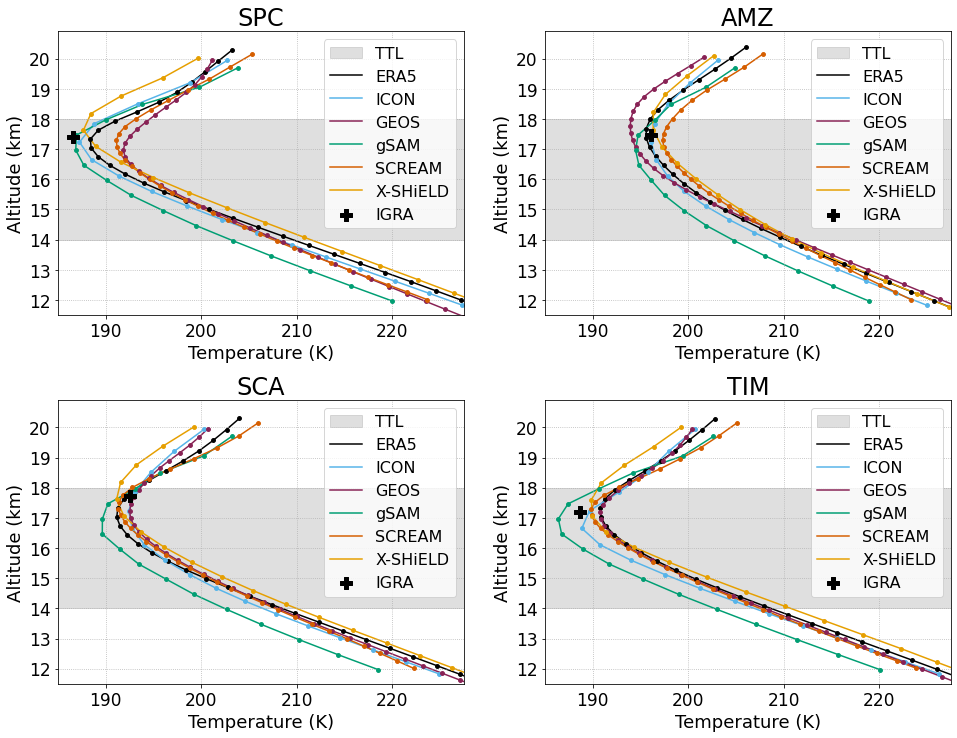

In [25]:
model_names = ["ERA5", "ICON", "GEOS", "SAM", "SCREAM", "SHIELD"]

# ERA5, SCREAM, SHIELD, GEOS are dictionaries - height changes by region
z_dicts = {
    "SAM": tavg_dict["SCA"]["SAM"].z,
    "ICON": alt_i,
    "SCREAM": alt_sc,
    "SHIELD": z_sh_dict,
    "GEOS": z_g_dict,
    "ERA5": z_e_dict
}

plot_avg_temp_profiles_all(tavg_dict, z_dicts, soundings_dict, region_list, model_names, 
                           title_dict, tsize=24, fsize=18, save=True)
